IA & Data science (LU3IN0226) -- 2020-2021
--------
*&copy; Equipe pédagogique: Vincent Guigue, Christophe Marsala, Edoardo Sarti, Olivier Schwander.*

# TD-TME08: algorithme des k-moyennes

L'objectif de ce notebook est d'implémenter l'algorithme des K-moyennes.

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

KRISNI Almehdi - 3800519

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Compléter le nom de ce notebook en rajoutant les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">**[Q]**</font> **Mise à jour de la librairie `iads`**

En premier lieu, vérifier que votre librairie `iads` est bien à jour : 
- dans le fichier `Classifieurs.py`: tous les classifieurs que vous avez implémentés depuis le début des séances. Rajouter aussi dans ce fichier la fonction `leave_one_out` écrite dans le notebook précédent.
- de même, vérifier que votre fichier `utils.py` est aussi à jour.

Une fois à jour, importer la librairie pour pouvoir l'utiliser dans ce notebook.

In [417]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Travail à réaliser
Le travail à faire se décompose en 2 phases :
- dans un premier temps, le travail porte sur la base d'apprentissage <code>base-2D.csv</code> qui contient des exemples décrits dans $R^2$. Ainsi, il est plus aisé de visualiser les résultats des fonctions à écrire ;
- dans un second temps, les fonctions écrites dans la phase précédente sont à utiliser avec la base d'apprentissage "base-Paris.csv".

**Attention**: vos fonctions doivent **dès leur création** pouvoir s'appliquer **quelle que soit la dimension** des exemples traités.


### Données d'expérimentation

Commencer par charger le fichier <code>base_2D.csv</code> qui permettra d'expérimenter vos fonctions. Dans ce qui suit, on note <code>data_2D</code> le dataframe qui contient les données de ce fichiers.


In [418]:
data_2D = pd.read_csv("data/base-2D.csv")
data_2D[0:5] 

,X,Y
0,0.0,4.0
1,1.0,3.5
2,1.0,1.0
3,2.0,1.0
4,2.0,2.0


On convertit le dataframe en array:

In [419]:
# Passer du dataframe à des arrays:
data_desc = np.array(data_2D[['X','Y']])

# obtenir les noms des colonnes :
data_noms = ['X','Y']

In [420]:
print("Minima: ",data_desc.min(axis=0), "\tMaxima:",data_desc.max(axis=0))

Minima:  [0. 1.] 	Maxima: [7. 6.]


In [421]:
print(np.asarray([0., 1.]) - data_desc.max(axis=0))

[-7. -5.]


Dans la suite de ce notebook, on appelle "base d'apprentissage" l'ensemble des exemples d'apprentissage obtenus après chargement et conversion en array.

**Rappel**: en apprentissage non-supervisé une base d'apprentissage ne contient que les descriptions des exemples, il n'y a pas de labels (classes) associés.

## Partie 1 : fonctions utiles

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>normalisation()</code>: cette fonction doit prendre en argument un <code>array A</code> et rendre l'array obtenu en normalisant <code>A</code> par la méthode vue en cours 8.

*Remarque*: avec les array numpy, il n'est pas nécessaire de faire des boucles...

In [422]:
def normalisation(A) :
    # On renvoie l'array A normalisé
    return np.asarray([((A[i] - A.min(axis=0)) / (A.max(axis=0) - A.min(axis=0))) for i in range(len(A))])

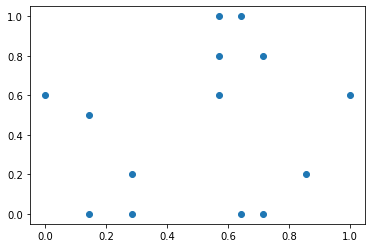

In [423]:
# Affichage des points après normalisation:

data_norm = normalisation(data_desc)

plt.scatter(data_norm[:,0],data_norm[:,1])

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>dist_vect()</code> qui calcule la distance euclidienne entre deux vecteurs représenté sous forme d'<code>array</code>.

In [424]:
def dist_vect(vect1, vect2) :
    # Renvoie la distance vectorielle entre les vecteurs vect1 et vect2
    return np.linalg.norm(vect1 - vect2)

In [425]:
dist_vect(data_norm[0,:],data_norm[1,:])

0.17437936593905287

### Calcul de centroides

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>centroide()</code> qui, étant un ensemble d'exemples, contenant au moins 2 exemples donné sous la forme d'un array rend leur centroide (sous la forme d'un array).

In [426]:
def centroide(desc) :
    # Renvoie le centroide (sous forme d'array) d'un ensemble d'exemples
    return np.asarray([np.mean(desc[:,i]) for i in range(len(desc[0]))])

In [427]:
print("Ensemble d'exemples: \n",data_norm[0:2,:])

print("Centroide correspondant:\n",centroide(data_norm[0:2,:]))

Ensemble d'exemples: 
 [[0.         0.6       ]
 [0.14285714 0.5       ]]
Centroide correspondant:
 [0.07142857 0.55      ]


In [428]:
centroide(data_norm)

array([0.51020408, 0.45      ])

Dans ce qui suit, on appelle "ensemble de centroides" un array contenant $K$ vecteurs de dimensions $p$.

## Partie 2: implémentation des k-moyennes

### Inertie d'un cluster
<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>inertie_cluster</code> qui, étant donné un array contenant un ensemble d'exemples contenant au moins 2 exemples, rend la valeur de l'inertie de cet ensemble telle qu'elle a été définie dans le cours.

In [429]:
import math as mt

def inertie_cluster(desc) :
    # Renvoie la valeur de l'inertie de l'ensemble
    
    # Calcul du centroide des exemples
    centre = centroide(desc)
    
    # Calcul de l'inertie du cluster
    # for i in range(len(desc)) :
    #   print("centre:", centre, "\tExemple:", desc[i], "\tdistance =", mt.pow(np.linalg.norm(centre - desc[i]), 2))
    return sum([mt.pow(np.linalg.norm(desc[i] - centre), 2) for i in range(len(desc))])

In [430]:
np.set_printoptions(precision=3) # pour n'afficher que 3 chiffres au plus après la virgules...

print("inertie de l'ensemble :",inertie_cluster(data_norm))

np.set_printoptions(precision=8) # On remet comme c'était avant

inertie de l'ensemble : 2.975991253644316


In [431]:
print("inertie de l'ensemble :",inertie_cluster(data_norm[0:2,:]))

inertie de l'ensemble : 0.01520408163265306


<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>initialisation()</code> qui étant donné un entier $K>1$ et une base d'apprentissage de $n$ exemples rend un array contenant $K$ exemples tirés aléatoirement dans la base.
On fait l'hypothèse que $K\leq n$.

*Remarque*: étudier les fonctions de la librairie random de Python...


In [432]:
import random as rd

def initialisation(K, desc) :
    # On renvoie K exemples tirés aléatoirements
    selection = []
    
    while (len(selection) < K) :
        val = rd.randint(0, len(desc) - 1)
        if val not in selection :
            selection.append(val)
            
    print("Sélectionnés:", selection)
    
    return desc[selection]

In [433]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# Par exemple (mais vous ne devriez pas pouvoir retrouver exactement les mêmes !)
Centroides_test = initialisation(3,data_norm)
Centroides_test

Sélectionnés: [10, 1, 11]


array([[0.71428571, 0.        ],
       [0.14285714, 0.5       ],
       [0.71428571, 0.8       ]])

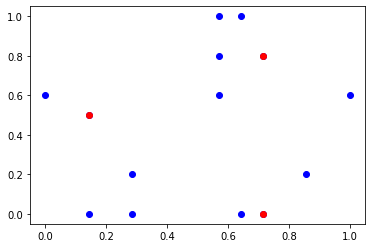

In [434]:
plt.scatter(data_norm[:,0],data_norm[:,1],color='blue')
plt.scatter(Centroides_test[:,0],Centroides_test[:,1],color='red')

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>plus_proche()</code> qui, étant donné un exemple et un array contenant un ensemble de centroides, rend l'indice du array correspondant au centroide dont l'exemple est le plus proche.
En cas d'égalité de distance, le centroide de plus petit indice est choisi.

In [435]:
def plus_proche(exemple, centroides) :
    # On cherche l'indice du centroide le plus proche
    indice = 0
    
    # On parcourt les differents centroides afin de trouver le plus proche
    for i in range(len(centroides)) :
        if (np.linalg.norm(exemple - centroides[i]) < np.linalg.norm(exemple - centroides[indice])) :
            indice = i
            
    return indice

In [436]:
for i in range(0,len(data_norm)):
    pproche = plus_proche(data_norm[i,:],Centroides_test)
    print(pproche)

1
1
1
0
1
2
2
2
0
2
0
2
0
2


### Matrice d'affectation

Etant donné une base d'apprentissage, on peut représenter une partition de cette base en K clusters à l'aide d'une matrice U contenant n lignes (une par exemple) et K colonnes (une par cluster) et telle que les contraintes suivantes sont vérifiées: 
- U[i,j] = 1 si l'exemple i appartient au cluster j
- U[i,j] = 0 si l'exemple i n'appartient pas au cluster j
- un exemple appartient à un et un seul cluster
- un cluster contient au moins un exemple

On appelle **matrice d'affectation** une telle matrice U.


<font size="+1" color="RED">**[Q]**</font> Donner une expression mathématique (pas du Python) des 2 dernières contraintes que vérifie une matrice d'affectation.

(à faire sur feuille)

### Implémentation en Python
Nous utilisons un dictionnaire pour représenter d'une matrice d'affectation: 
- les clés de ce dictionnaire correspondent aux $K$ indices des clusters
- les valeurs correspondent à des listes d'indices d'exemples (leur indice dans la base d'apprentissage)

Dans tout ce qui suit, une "matrice d'affectation" sera un tel dictionnaire.


<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>affecte_cluster()</code> qui, étant donné une base d'apprentissage et un ensemble de $K$ centroïdes, rend la matrice d'affectation des exemples de la base aux clusters représentés par chaque centroïde.

In [437]:
def affecte_cluster(desc, centroides) :
    # On renvoie la matrice d'affectation des exemples aux clusters
    
    # Préparation de la matrice
    matrice = dict()
    for k in range(len(centroides)) :
        matrice[k] = list()
        
    # On parcout l'ensemble des exemples et on append au cluster correspondant
    for i in range(len(desc)) :
        indice = plus_proche(desc[i], centroides)
        matrice[indice].append(i)
        
    # On convertit en nparray les données
    for k in range(len(centroides)) :
        matrice[k] = np.array(matrice[k])
        
    # On renvoie la matrice
    return matrice

In [438]:
DictAffect = affecte_cluster(data_norm, Centroides_test)
DictAffect

{0: array([ 3,  8, 10, 12]),
 1: array([0, 1, 2, 4]),
 2: array([ 5,  6,  7,  9, 11, 13])}

### Ensemble des centroides
Grâce à la matrice d'affectation, on peut maintenant trouver les nouveaux centroides. Ceux-ci sont déterminés en prenant les moyennes des ensembles des exemples qui sont affectés au même cluster.

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>nouveaux_centroides()</code> qui, étant donné une base d'apprentissage et une matrice d'affectation, rend l'ensemble des nouveaux centroides obtenus.

In [439]:
def nouveaux_centroides(desc, matrice) :
    # On renvoie la position des nouveaux centroides
    new_centroides = list()
    
    # On parcourt les points liés à chaque centroide
    for k in matrice.keys() :
        liste = matrice[k]
        new_centroides.append(centroide(data_norm[matrice[k]]))
        
    # On renvoie les nouveaux centroides
    return new_centroides

In [440]:
data_norm[DictAffect[0]]

array([[0.28571429, 0.        ],
       [0.64285714, 0.        ],
       [0.71428571, 0.        ],
       [0.85714286, 0.2       ]])

In [441]:
centroide(data_norm[DictAffect[0]])

array([0.625, 0.05 ])

In [442]:
nouveaux_centroides(data_norm, DictAffect)

[array([0.625, 0.05 ]),
 array([0.14285714, 0.325     ]),
 array([0.67857143, 0.8       ])]

### Inertie globale d'une partition

<font size="+1" color="RED">**[Q]**</font> En utilisant la fonction `inertie_cluster()`, écrire la fonction `inertie_globale()` qui, étant donné une base d'apprentissage et une matrice d'affectation, rend la valeur de l'inertie globale du partitionnement correspondant.


In [443]:
def inertie_globale(desc, matrice) :
    # On renvoie l'inertie globale d'une base de données
    in_glb = 0

    # On parcourt la matrice d'affectation
    for i in matrice.keys() :
        in_glb += inertie_cluster(desc[matrice[i]])
        
    return in_glb

In [444]:
np.set_printoptions(precision=3) # pour n'afficher que 3 chiffres au plus après la virgules...

print("Inertie globale: ",inertie_globale(data_norm,DictAffect))

np.set_printoptions(precision=8) # pour n'afficher que 3 chiffres au plus après la virgules...

Inertie globale:  0.7759183673469388


### Algorithme des K-moyennes

<font size="+1" color="RED">**[Q]**</font> En utilisant les fonctions précédentes, implémenter l'algorithme des K-moyennes.
Pour cela, écrire une fonction <code>kmoyennes()</code> qui prend en argument un entier $K>1$, une base d'apprentissage, ainsi que deux nombres: un réel *epsilon*$>0$ et un entier *iter_max*$>1$, et qui rend un ensemble de centroides et une matrice d'affectation.

Le réel *epsilon* sert de critère de convergence, et l'entier *iter_max* est utilisé pour fixer un nombre d'itérations maximal servant à arrêter le calcul.

In [445]:
import math as mt

def kmoyennes(K, desc, epsilon, iter_max=1000) :
    # On renvoie un ensemble de centroides et une matrice d'affectation
    
    # On initialise les K centroides
    centroides = initialisation(K, desc)
    
    # On affecte les données à un cluster
    affect = affecte_cluster(desc, centroides)
    
    # Historique des inerties globales
    print("Iteration 0\tInertie :", inertie_globale(desc, affect))
    histo_inertie_glb = [inertie_globale(desc, affect)]
    
    for i in range(1, iter_max) :
        # Recalcul des centroides
        centroides = nouveaux_centroides(desc, affect)
        
        # Nouvelle affectation
        affect = affecte_cluster(desc, centroides)
        
        # Calcul de la nouvelle inertie globale
        histo_inertie_glb.append(inertie_globale(desc, affect))
        
        # Affichage de la situation
        difference = mt.sqrt(mt.pow(histo_inertie_glb[i] - histo_inertie_glb[i - 1], 2))
        print("Iteration", i, "\tInertie :", histo_inertie_glb[i], "\tDifference :", difference)
        
        # Vérification de epsilon
        if (difference < epsilon) :
            print("\nSortie de l'algorithme - Difference des inerties inférieure à epsilon\n")
            return centroides, affect
        
    print("\nSortie de l'algortihme - Nombre d'itérations maximal dépassé\n")
    return centroides, affect

In [446]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(2, data_norm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

Sélectionnés: [8, 6]
Iteration 0	Inertie : 1.427942176870748
Iteration 1 	Inertie : 1.427942176870748 	Difference : 0.0

Sortie de l'algorithme - Difference des inerties inférieure à epsilon

Affichage des centres:  [array([0.48809524, 0.06666667]), array([0.52678571, 0.7375    ])]
Affichage des affectations:  {0: array([ 2,  3,  4,  8, 10, 12]), 1: array([ 0,  1,  5,  6,  7,  9, 11, 13])}


In [447]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(3, data_norm, 0.05, 100)

les_centres = np.array(les_centres)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

Sélectionnés: [3, 7, 6]
Iteration 0	Inertie : 1.3100262390670554
Iteration 1 	Inertie : 1.2269727891156463 	Difference : 0.08305344995140906
Iteration 2 	Inertie : 1.1791904761904763 	Difference : 0.04778231292516999

Sortie de l'algorithme - Difference des inerties inférieure à epsilon

Affichage des centres:  [[0.48809524 0.06666667]
 [0.60714286 1.        ]
 [0.5        0.65      ]]
Affichage des affectations:  {0: array([ 2,  3,  4,  8, 10, 12]), 1: array([ 7,  9, 11]), 2: array([ 0,  1,  5,  6, 13])}


On peut réaliser un affichage couleur des centroïdes trouvés:

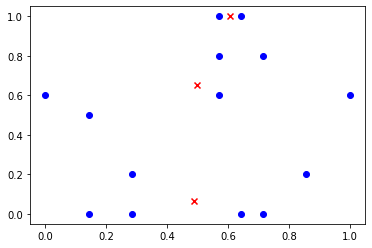

In [448]:
plt.scatter(data_norm[:,0],data_norm[:,1],color='b')
plt.scatter(les_centres[:,0],les_centres[:,1],color='r',marker='x')

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>affiche_resultat()</code> qui permet d'afficher le résultat de l'algorithme en utilisant des couleurs différentes pour les clusters trouvés (pour faire simple, on peut ne considèrer que le cas où K vaut 3).

*Remarque*: La librairie matplotlib permet de manipuler aisément des couleurs:
http://matplotlib.org/api/cm_api.html

In [449]:
import random as rd

def affiche_resultat(data, centroides, affectation) :
    # On plot en croix rouges les centroides
    plt.scatter(les_centres[:,0], les_centres[:,1], color='r', marker='x')
    
    # On plot chaque cluster d'une couleur différente
    for i in range(len(centroides)) :
        # On génère une couleur aléatoire
        r = rd.random()
        b = rd.random()
        g = rd.random()
        c = (r, b, g)
        
        # On récupère les points
        data_norm = data[affectation[i]]
        
        # On plot le cluster
        plt.scatter(data_norm[:,0], data_norm[:,1], color=c)

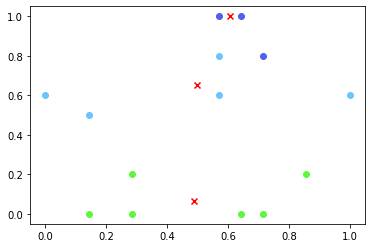

In [450]:
affiche_resultat(data_norm,les_centres,l_affectation)

### Expérimentations

<font size="+1" color="RED">**[Q]**</font> Expérimenter l'algorithme des k-moyennes sur les données. Etudier l'impact du choix de $K$ sur l'inertie globale finale. Faire de même en relançant plusieurs fois l'algorithme avec la même valeur de $K$, en modifiant la valeur de epsilon ou de max_iter, etc.

## Questions de cours (à faire sur feuille)

Pour vous entraîner sans machine...

<font size="+1" color="RED">**[Q]**</font> On considère un ensemble fini $U$ d'éléments. 
- donner la fonction caractéristique de $U$
- donner la fonction caractéristique de l'ensemble vide
- soit $E$ et $F$ deux sous-ensembles de $U$ définis par leurs fonctions caractéristiques $\chi_E$ et $\chi_F$. En déduire les fonctions caractéristiques de $E\cup F$, de $E\cap F$ et de $E^{c}$. *(indice: penser au min et au max)*

<font size="+1" color="RED">**[Q]**</font> Rappeler la définition d'une partition $P$ d'un ensemble $X$ en $K$ sous-ensembles. 

<font size="+1" color="RED">**[Q]**</font> Appliquer, à la main, l'algorithme des K-moyennes sur les données fournies sur le transparent 8 du cours 9 en utilisant d'abord $K=2$, puis $K=3$. Dans chacun des cas, réaliser au maximum 10 itérations de l'algorithme ($t_{max}=10$).
Comparer les résultats obtenus.


---